# 🤖 Web Scraping y Visualización de la Inflación Argentina

## 📚 Importación de librerías

In [1]:
# Manejo del tiempo para cronometrar el programa y manejar datos tipo fecha
import time
comienzo = time.perf_counter()
import datetime as dt
from datetime import datetime
import locale

# Manejar datos y cálculos
import pandas as pd
import numpy as np

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Crear gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, MultipleLocator, AutoMinorLocator
import seaborn as sns

In [2]:
# Fuente
web_bcra = "https://www.bcra.gob.ar/PublicacionesEstadisticas/Principales_variables.asp"

## 🤖 Web Scraping

In [4]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bcra)

inflacion_mensual = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div/div/div/table/tbody/tr[39]/td[1]/a"
)
inflacion_mensual.click()

# Guardemos los valores de los atributos min y max
input_fecha_hasta = driver.find_element_by_name('fecha_hasta')
input_fecha_hasta_min = input_fecha_hasta.get_attribute('min')
input_fecha_hasta_max = input_fecha_hasta.get_attribute('max')
# Las fechas son %Y-%m-%d, hay que convertir a %d-%m-%y
input_fecha_hasta_min = datetime.strptime(input_fecha_hasta_min, "%Y-%m-%d").strftime("%d-%m-%Y")
input_fecha_hasta_max = datetime.strptime(input_fecha_hasta_max, "%Y-%m-%d").strftime("%d-%m-%Y")

filtro_fecha_inicio = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/input[1]"
)
filtro_fecha_inicio.send_keys(input_fecha_hasta_min)

# Fecha máxima
filtro_fecha_fin = driver.find_element(
        "xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/input[2]"
)
filtro_fecha_fin.send_keys(input_fecha_hasta_max)

time.sleep(2)

# Click en consultar
boton_filtrar = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located(
        ("xpath", "/html/body/div/div[2]/div/div[2]/div/div/form/button")
    )
)
driver.execute_script("arguments[0].click();", boton_filtrar)

time.sleep(2)

# Tomamos el contenido HTML de la tabla
tabla = driver.find_element(
    "xpath", "/html/body/div/div[2]/div/div[2]/div/div/table"
)
tabla = tabla.get_attribute("outerHTML")

driver.close()

# Como en Argentina usamos la , en vez del . como Python, entonces los datos vienen mal de por sí
# Lo corregimos agregando que el separador de miles de la tabla sea , y no .
inflacion_df = pd.read_html(tabla, thousands='.', decimal=',')[0]
inflacion_df

,Fecha,Valor
0,28/02/1943,-0.6
1,31/03/1943,1.6
2,30/04/1943,0.7
3,31/05/1943,-0.9
4,30/06/1943,0.1
...,...,...
961,31/03/2023,7.7
962,30/04/2023,8.4
963,31/05/2023,7.8
964,30/06/2023,6.0


## 📊 Manipulación

In [5]:
inflacion_df = inflacion_df.rename(columns = {"Valor":"Inflación"})
#Convertimos la primer columna a mm/yyyy
locale.setlocale(locale.LC_TIME, 'es_ES.utf8')
#Especificamos el formato de entrada, para después editarlo
inflacion_df['Fecha'] = pd.to_datetime(inflacion_df['Fecha'], format='%d/%m/%Y')
#Editamos el formato de las fechas, no tiene sentido tener el último día del mes
inflacion_df.Fecha = pd.to_datetime(inflacion_df.Fecha).dt.strftime('%b-%y')
#Convertimos la Fecha en índice
inflacion_df.set_index('Fecha', inplace=True)
inflacion_df

,Inflación
Fecha,
feb.-43,-0.6
mar.-43,1.6
abr.-43,0.7
may.-43,-0.9
jun.-43,0.1
...,...
mar.-23,7.7
abr.-23,8.4
may.-23,7.8


## 📈 Visualización de la Inflación Mensual

¡No hay que dejar de tener en cuenta que la inflación siempre acumula, es decir el aumento de los precios puede ser menor, pero siempre será más caro que antes!

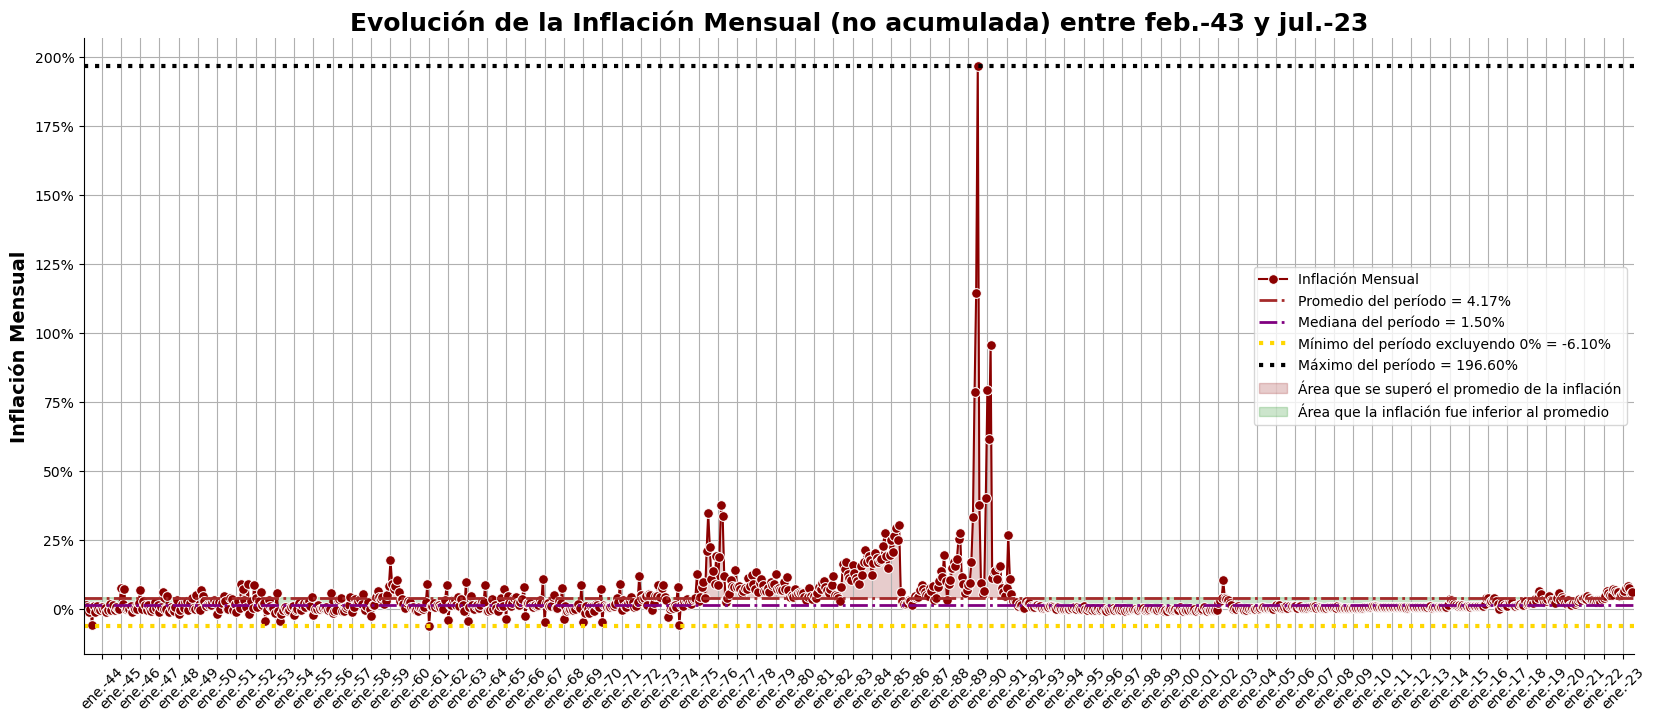

In [6]:
#Gráfico inflación mensual NO ACUMULADA
cantidad_filas = inflacion_df.shape[0]
fecha_min = inflacion_df.index[0]
fecha_max = inflacion_df.index[-1]
inflacion_min = min(inflacion_df["Inflación"][inflacion_df["Inflación"] != 0])
inflacion_max = max(inflacion_df["Inflación"])

plt.figure(figsize=(20, 8))
sns.lineplot(
    x="Fecha",
    y="Inflación",
    label="Inflación Mensual",
    data=inflacion_df,
    color="darkred",
    marker='o',
    markersize=7,
    linewidth=1.5
)

# Configurar los ticks del eje X para mostrar cada 6 meses
plt.xticks(range(-1, cantidad_filas, 12), rotation=45)
plt.xlim(0, cantidad_filas - 1)

titulo = f'Evolución de la Inflación Mensual (no acumulada) entre {fecha_min} y {fecha_max}'
plt.title(titulo,
         fontweight="bold",
         fontsize=18)
plt.ylabel("Inflación Mensual",
          fontweight="bold",
          fontsize=14)
plt.xlabel("")

#gca = Get Current Axis
plt.gca().yaxis.set_major_formatter(FuncFormatter("{:,.0f}%".format))

plt.xlim(0, cantidad_filas)

# Linea promedio total horizontal
promedio_periodo = inflacion_df["Inflación"].mean()
plt.axhline(
    promedio_periodo,
    color="brown",
    linestyle="-.",
    linewidth=2,
    label=f"Promedio del período = {promedio_periodo:.2f}%"
)

# Linea mediana total horizontal
mediana_periodo = inflacion_df["Inflación"].median()
plt.axhline(
    mediana_periodo,
    color="purple",
    linestyle="-.",
    linewidth=2,
    label=f"Mediana del período = {mediana_periodo:.2f}%"
)

# Linea mínimo diferente a 0 horizontal
plt.axhline(
    inflacion_min,
    color="gold",
    linestyle=":",
    linewidth=3,
    label=f"Mínimo del período excluyendo 0% = {inflacion_min:.2f}%"
)

# Linea máximo horizontal
plt.axhline(
    inflacion_max,
    color="black",
    linestyle=":",
    linewidth=3,
    label=f"Máximo del período = {inflacion_max:.2f}%"
)

# Rellenamos el espacio entre la inflación y el promedio
plt.fill_between(
    inflacion_df.index,
    promedio_periodo,
    inflacion_df["Inflación"],
    color="darkred",
    alpha=0.2,
    label="Área que se superó el promedio de la inflación",
    where=(inflacion_df["Inflación"] > promedio_periodo)
)
plt.fill_between(
    inflacion_df.index,
    inflacion_df["Inflación"],
    promedio_periodo,
    color="green",
    alpha=0.2,
    label="Área que la inflación fue inferior al promedio",
    where=(inflacion_df["Inflación"] < promedio_periodo)
)

plt.legend()
plt.grid(True)
sns.despine()

#Guardar como jpg
plt.savefig(f"{titulo}.jpg")
plt.show()

Vemos que la inflación es bastante volátil, aunque en los últimos meses se incrementó con más rapidez previo a las elecciones.

## 📈 Visualización de la Inflación Agregada

La inflación al ser porcentual, para poder sumarla, debemos multiplicar su valor mes a mes, siempre agregándole 1. De esta manera, al graficar, vamos a obtener un palo de hockey, lo cual nos haría pensar que la inflación incrementó extremadamente mucho en el último tiempo. Esto no es exactamente correcto, ya que al multiplicarse todos los valroes anteriores, es obvio que la inflación crecerá en forma exponencial. Esto ocurre con muchas variables de la economía, puesto que muchas variables son acumulativas.

In [7]:
#A la columna inflación la dividimos por 100 para que sea %, le sumamos 1 para poder multiplicar
#Le aplicamos cumprod (multiplica acumuladamente) y le restamos el uno que sumamos para cada fila
#Lo multiplicamos por 100 para que coincida con el formato de antes
inflacion_df["Inflación Agregada"] = ((inflacion_df["Inflación"]/100+1).cumprod()-1)*100
inflacion_df

,Inflación,Inflación Agregada
Fecha,,
feb.-43,-0.6,-6.000000e-01
mar.-43,1.6,9.904000e-01
abr.-43,0.7,1.697333e+00
may.-43,-0.9,7.820568e-01
jun.-43,0.1,8.828389e-01
...,...,...
mar.-23,7.7,4.479818e+17
abr.-23,8.4,4.856122e+17
may.-23,7.8,5.234900e+17


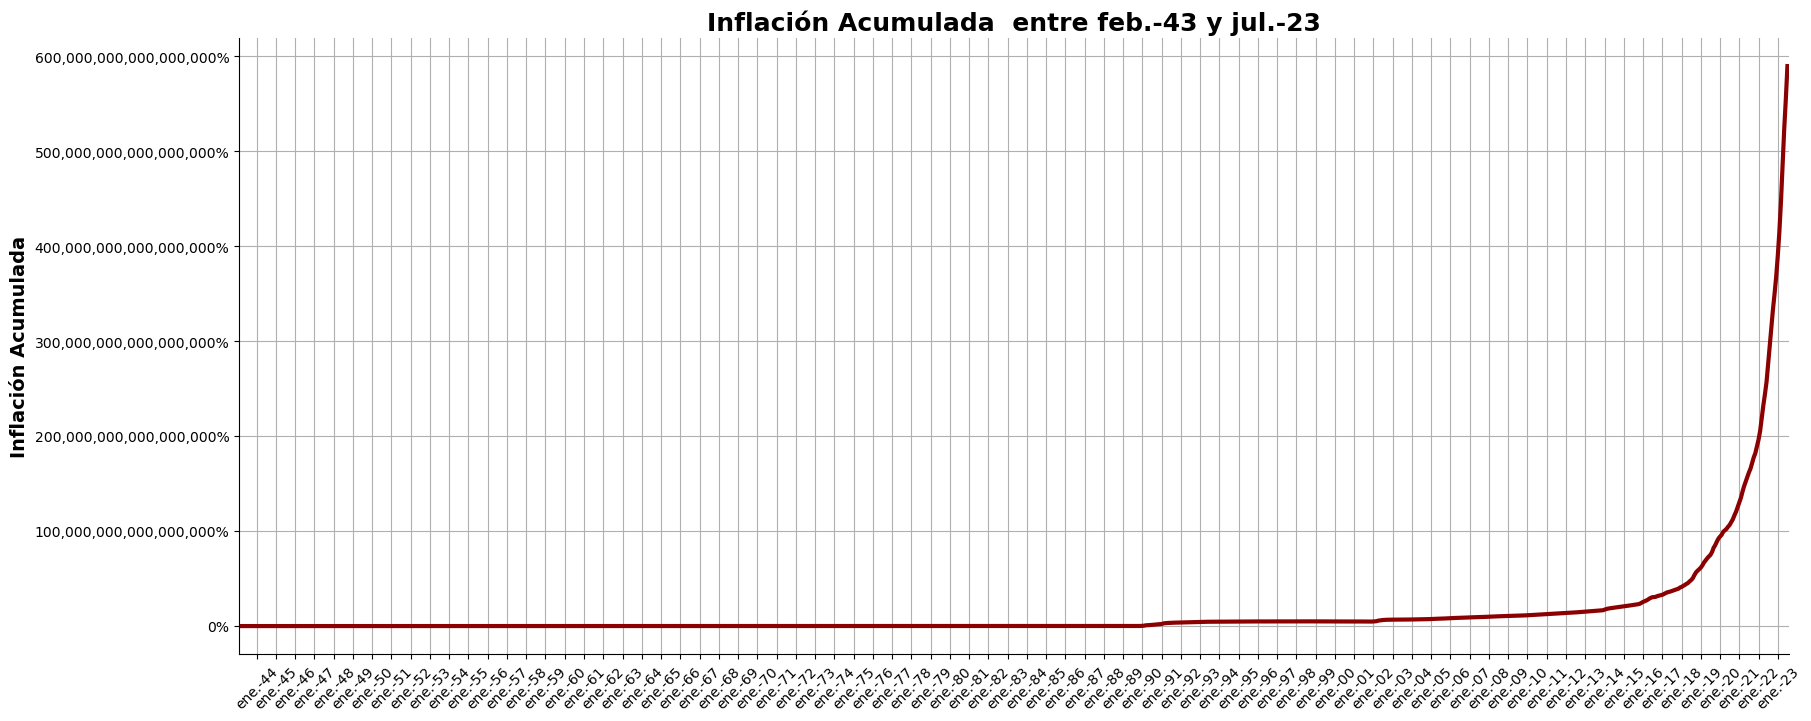

In [8]:
#Gráfico inflación mensual ACUMULADA
plt.figure(figsize=(20, 8))
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=3,
    legend=False
)

# Configurar los ticks del eje X para mostrar cada 12 meses
plt.xticks(range(-1, cantidad_filas, 12), rotation=45)
plt.xlim(0, cantidad_filas - 1)

titulo = f"Inflación Acumulada  entre {fecha_min} y {fecha_max}"
plt.title(titulo,
         fontweight="bold",
         fontsize=18)
plt.ylabel("Inflación Acumulada",
          fontweight="bold",
          fontsize=14)

plt.gca().yaxis.set_major_formatter(FuncFormatter("{:,.0f}%".format))

plt.xlim(0, cantidad_filas)
plt.xlabel("")

plt.grid(True)
sns.despine()

plt.savefig(f"{titulo}.jpg")
plt.show()

## 📈 Visualización de la Inflación Agregada (escala logarítmica)

Mediante la escala logarítmica podemos suavizar el crecimiento de la inflación acumulada, de manera que los últimos periodos no se llevan todo el peso de la acumulación. Lo importante es ver cambios de pendiente. La contra es que es difícil de leer (y no es tan dramático 😉).

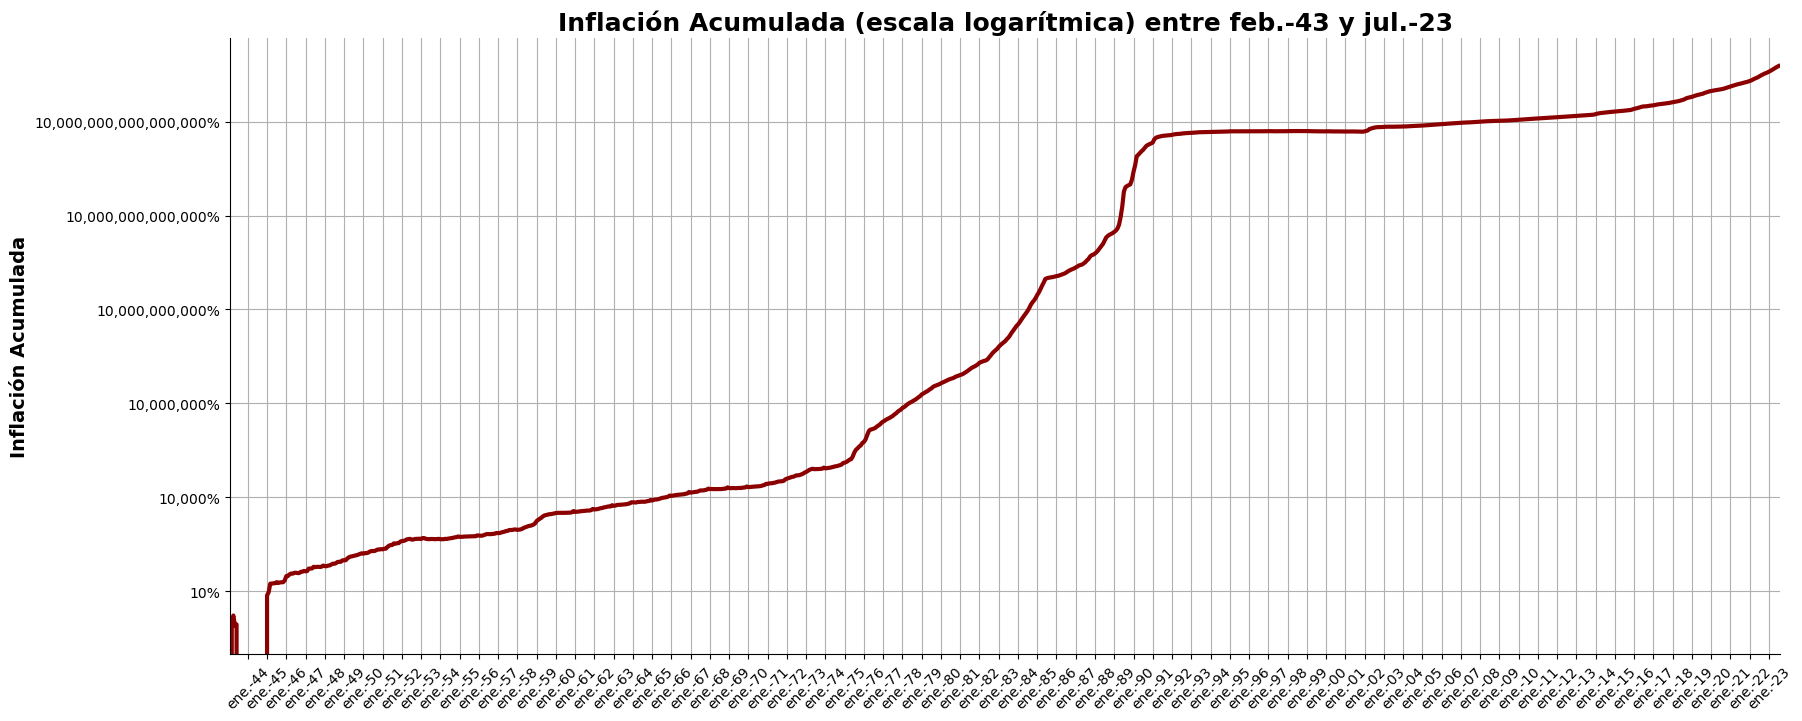

In [12]:
#Gráfico inflación mensual ACUMULADA logarítmica
plt.figure(figsize=(20, 8))
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=3,
    legend=False
).set_yscale("log")

# Configurar los ticks del eje X para mostrar cada 12 meses
plt.xticks(range(-1, cantidad_filas, 12), rotation=45)
plt.xlim(0, cantidad_filas - 1)

titulo = f"Inflación Acumulada (escala logarítmica) entre {fecha_min} y {fecha_max}"
plt.title(titulo,
         fontweight="bold",
         fontsize=18)
plt.ylabel("Inflación Acumulada",
          fontweight="bold",
          fontsize=14)

plt.gca().yaxis.set_major_formatter(FuncFormatter("{:,.0f}%".format))


plt.xlim(0, cantidad_filas)
plt.xlabel("")

plt.grid(True)
sns.despine()

plt.savefig(f"{titulo}.jpg")
plt.show()

Exportamos los datos a Excel para conservar y dar otros usos.

In [10]:
inflacion_df.to_excel("inflacion_df.xlsx")